<a href="https://colab.research.google.com/github/V-Pavan-Sastry/Pytorch/blob/main/riceTypeClassifications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: vpavansastry
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████| 888k/888k [00:00<00:00, 88.6MB/s]

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#set the device based on availabiltiy of gpu in run time
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
# making sure that data is downloaded and availble to be used
data_df =pd.read_csv("/content/rice-type-classification/riceClassification.csv")
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [ ]:
#basic preprocessing
data_df.dropna(inplace=True) # drops rows with any value not available
data_df.drop(['id'],axis=1,inplace=True) # dropping id as it is not useful and axis =1 denotes we are referring to a column
print(data_df.shape)

(18185, 11)


In [ ]:
data_df.head() #Checking if that worked


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [ ]:
print(data_df['Class'].unique()) #denotes different labels to be classified
print(data_df['Class'].value_counts()) #denotes the number of datapoints for each class available in the dataset

[1 0]
Class
1    9985
0    8200
Name: count, dtype: int64


In [ ]:
#Normalization
original_df = data_df.copy()
for column in data_df.columns:
  data_df[column] = data_df[column]/data_df[column].abs().max() # abs is to avoid negative values
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [ ]:
# Creating the training data
X = np.array(data_df.iloc[:,:-1]) #[:,:-1] all rows and all columns except the label
Y = np.array(data_df.iloc[:,-1]) #all rows and last column

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size= 0.3) #Splitting data into training and testing

In [ ]:
X_test,X_val,Y_test,Y_val = train_test_split(X_test,Y_test,test_size=0.5) #Splitting the testing data for validation and testing

In [ ]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)
print(X_val.shape,Y_val.shape) # Checking if the splitting was performed perfectly

(12729, 10) (12729,)
(2728, 10) (2728,)
(2728, 10) (2728,)


In [ ]:
#Convert numpy arrays to torch dataset
class dataset(Dataset):
  def __init__(self,X,Y):
    self.X =torch.tensor(X,dtype=torch.float32).to(device)
    self.Y =torch.tensor(Y,dtype=torch.float32).to(device)
  def __len__(self):
    return len(self.X)
  def __getitem__(self, index):
    return self.X[index],self.Y[index]

In [ ]:
training_data = dataset(X_train,Y_train)
testing_data = dataset(X_test,Y_test)
validation_data = dataset(X_val,Y_val)

In [ ]:
train_dataloader = DataLoader(training_data,batch_size = 32  ,shuffle = True)
test_dataloader = DataLoader(testing_data,batch_size = 32 ,shuffle = True)
val_dataloader = DataLoader(validation_data,batch_size = 32 ,shuffle = True) #DataLoader is used to for batch data

In [ ]:
HIDDEN_NEURONS =10
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel,self).__init__()
    self.input_layer = nn.Linear(X.shape[1],HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS,1) #output
    self.sigmoid = nn.Sigmoid() #activation function for binary classification
  def forward(self,x):
    x=self.input_layer(x)
    x=self.linear(x)
    x=self.sigmoid(x)
    return x

model = MyModel().to(device)

In [ ]:
summary(model,(X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(),lr=1e-3)

In [ ]:
total_loss_train_plot =[]
total_loss_validation_plot = []
total_acc_train_plot=[]
total_acc_validation_plot=[]

epochs=10
for epoch in range(epochs):
  total_acc_train=0
  total_loss_train=0
  total_acc_validation=0
  total_loss_validation=0
  for data in train_dataloader:
    inputs,labels = data
    #print(inputs)
    #print(labels)
    predictions = model(inputs).squeeze(1)
    #print(predictions)
    batch_loss =criterion(predictions,labels)
    #print(batch_loss)
    total_loss_train+=batch_loss.item()
    acc=((predictions).round()==labels).sum().item()
    #print(acc)
    total_acc_train+=acc

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  with torch.no_grad():
    for inputs,labels in val_dataloader:
      predictions = model(inputs).squeeze(1)
      batch_loss =criterion(predictions,labels)
      total_loss_validation+=batch_loss.item()
      acc=((predictions).round()==labels).sum().item()
      total_acc_validation+=acc
  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_loss_validation_plot.append(round(total_loss_validation/1000,4))
  total_acc_train_plot.append(round(total_acc_train/training_data.__len__() *100,4))
  total_acc_validation_plot.append(round(total_acc_validation/validation_data.__len__() *100,4))
  if len(total_acc_train_plot)>0:
    print(f"""Epoch no. {epoch+1}
    Training Loss {round(total_loss_train/1000,4)}
    Validation loss {round(total_loss_validation/1000,4)}
    Training Accuracy {round(total_acc_train/training_data.__len__() *100,4)}
    Validation Accuracy {round(total_acc_validation/validation_data.__len__() *100,4)}""")
  print("="*35)


Epoch no. 1 
    Training Loss 0.2403
    Validation loss 0.0392 
    Training Accuracy 79.3071
    Validation Accuracy 98.4238
Epoch no. 2 
    Training Loss 0.1185
    Validation loss 0.0157 
    Training Accuracy 98.1538
    Validation Accuracy 98.9003
Epoch no. 3 
    Training Loss 0.054
    Validation loss 0.0085 
    Training Accuracy 98.3895
    Validation Accuracy 98.8636
Epoch no. 4 
    Training Loss 0.0348
    Validation loss 0.0059 
    Training Accuracy 98.4131
    Validation Accuracy 98.9736
Epoch no. 5 
    Training Loss 0.0271
    Validation loss 0.0048 
    Training Accuracy 98.4995
    Validation Accuracy 98.717
Epoch no. 6 
    Training Loss 0.0234
    Validation loss 0.0041 
    Training Accuracy 98.5938
    Validation Accuracy 98.9003
Epoch no. 7 
    Training Loss 0.0212
    Validation loss 0.0037 
    Training Accuracy 98.5231
    Validation Accuracy 98.7537
Epoch no. 8 
    Training Loss 0.0198
    Validation loss 0.0034 
    Training Accuracy 98.6409
    Valida

In [ ]:
with torch.no_grad():
  total_loss_test=0
  total_acc_test=0
  for data in test_dataloader:
    inputs,labels = data
    predictions = model(inputs).squeeze(1)
    batch_loss =criterion(predictions,labels)
    total_loss_test+=batch_loss.item()
    acc=((predictions).round()==labels).sum().item()
    total_acc_test+=acc
  print(f"""Test Loss {round(total_loss_test/1000,4)}
  Test Accuracy {round(total_acc_test/testing_data.__len__() *100,4)}""")


Test Loss 0.0037 
  Test Accuracy 98.6437


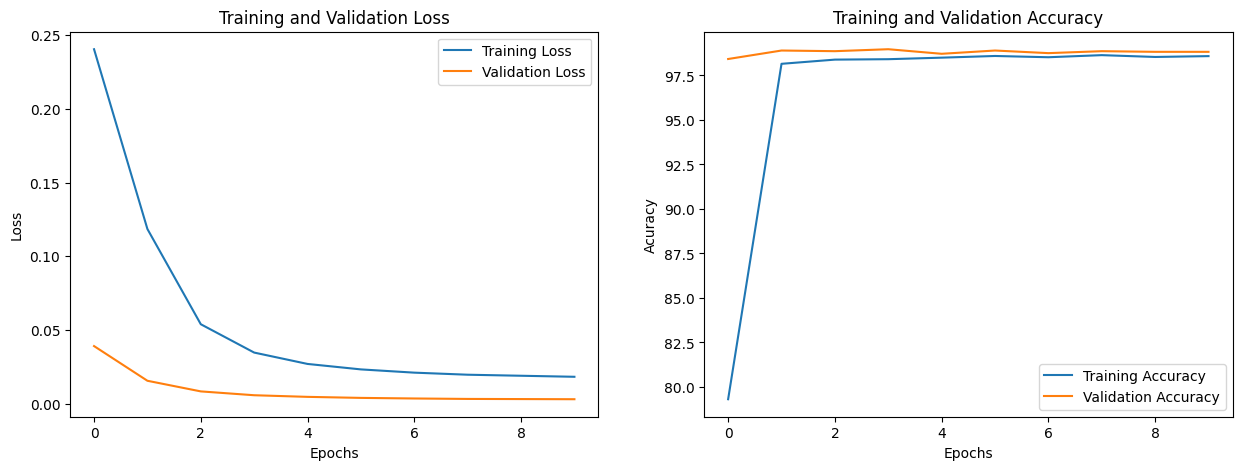

In [ ]:
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
axs[0].plot(total_loss_train_plot,label="Training Loss")
axs[0].plot(total_loss_validation_plot,label="Validation Loss")
axs[0].set_title("Training and Validation Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
#axs[0].set_ylim([0,2])
axs[0].legend()

axs[1].plot(total_acc_train_plot,label="Training Accuracy")
axs[1].plot(total_acc_validation_plot,label="Validation Accuracy")
axs[1].set_title("Training and Validation Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Acuracy")
#axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()

In [ ]:
Area = 5853/original_df["Area"].abs().max()
MajorAxisLength = 76.293164/original_df["MajorAxisLength"].abs().max()
MinorAxisLength = 51.928487/original_df["MinorAxisLength"].abs().max()
Eccentricity = 0.725553/original_df['Eccentricity'].abs().max()
ConvexArea = 3132/original_df["ConvexArea"].abs().max()
EquivDiameter = 62.551300/original_df["EquivDiameter"].abs().max()
Extent = 0.783529/original_df["Extent"].abs().max()
Perimeter = 210.012/original_df["Perimeter"].abs().max()
Roundness = 0.868434/original_df["Roundness"].abs().max()
AspectRation= 1.465950/original_df["AspectRation"].abs().max()

prediction =model(torch.tensor([Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation],dtype=torch.float32).to(device)).item()
print(prediction,round(prediction))

0.05347480997443199 0
